In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

from sim_env import PVModule, WTModule, Battery, HydroFuelCell, Demand, Price
from ems import NaiveAgent, RLAgent

from ems import cal_yc, cal_yf, reward_1, reward_2, reward_3, reward_4

In [11]:
season_config = {"winter": [24*31, 24*(31+31), "January"], 
                 "spring": [24*31, 24*(31+30), "April"], 
                 "summer": [24*30, 24*(30+31), "July"], 
                 "autumn": [24*30, 24*(30+31), "October"]}

# 数据导入
season = "autumn"
demands_df = pd.read_excel(f"./data/demands_{season}.xlsx")
prices_df = pd.read_excel(f"./data/prices_{season}.xlsx")
renewable_df = pd.read_excel(f"./data/renewable_{season}.xlsx")

# 数据整合
data = pd.concat([renewable_df, prices_df[["price"]], demands_df[["demand"]]], axis=1)

# 缩放新能源数据
wt_ratio = 2
pv_ratio = 1
data["renewable"] = pv_ratio * data["pv"] + wt_ratio * data["wt"]

In [12]:
data.head()

,timestamp,pv,wt,hour_of_day,price,demand,renewable
0,2023-09-01 00:00:00,0.0,20.483311,0,0.08823,207.99,40.966622
1,2023-09-01 01:00:00,0.0,19.054776,1,0.08311,197.50,38.109553
2,2023-09-01 02:00:00,0.0,19.054776,2,0.07990,193.64,38.109553
3,2023-09-01 03:00:00,0.0,12.899111,3,0.07728,187.71,25.798222
4,2023-09-01 04:00:00,0.0,5.441813,4,0.07552,185.57,10.883625


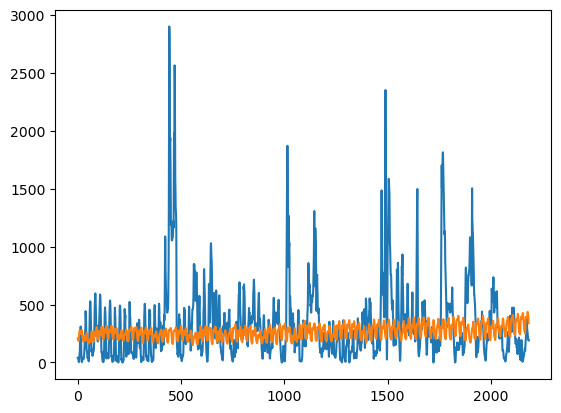

In [13]:
plt.plot(data["renewable"])
plt.plot(data["demand"])

In [14]:
# 拆分训练集和测试集
start_idx = season_config[season][0]
end_idx = season_config[season][1]

demands_train = data.iloc[0:start_idx][["demand", "hour_of_day"]]
demands_test = data.iloc[start_idx:end_idx][["demand", "hour_of_day"]]

renewable_train = data.iloc[0:start_idx][["pv", "wt", "renewable", "hour_of_day"]]
renewable_test = data.iloc[start_idx:end_idx][["pv", "wt", "renewable", "hour_of_day"]]

prices_train = data.iloc[0:start_idx][["price", "hour_of_day"]]
prices_test = data.iloc[start_idx:end_idx][["price", "hour_of_day"]]

In [15]:
print("训练集:", renewable_train.shape[0])
print("测试集:", renewable_test.shape[0])

训练集: 720
测试集: 744


In [16]:
# demands
demands = Demand(demands_train["demand"].values)

# prices
ele_prices = Price(prices_train["price"].values)

# renewable energy
pv_generator = PVModule(renewable_train["pv"].values)
wt_generator = WTModule(renewable_train["wt"].values)

# battery
max_capacity = 400    # kWh
min_capacity = max_capacity * 0.2
rated_charge = max_capacity * 0.25    # 充电系数0.25
rated_discharge = max_capacity * 0.25    # 放电系数0.25
charge_efficiency = 0.9
discharge_efficiency = 0.9
init_soc = 0.5

battery = Battery(min_capacity=min_capacity, max_capacity=max_capacity, rated_charge=rated_charge, rated_discharge=rated_discharge, 
                  charge_efficiency=charge_efficiency, discharge_efficiency=discharge_efficiency, init_soc=init_soc)

# fuelcell
min_capacity = 0
max_capacity = 100   # kg
rated_soel = 300   # kWh
rated_sofc = 150   # kWh
e2h = 0.0304   # 1kWh电产生的氢气重量kg
h2e = 32.9   # 1kg气体产生多少电量kWh
soel_efficiency = 0.65   # 电解效率
sofc_efficiency = 0.60   # 放电效率
hydrogen_price = 1.142   # pound/kg
init_soc = 0.5

fc = HydroFuelCell(min_capacity=min_capacity, max_capacity=max_capacity, rated_soel=rated_soel, rated_sofc=rated_sofc, e2h=e2h, h2e=h2e, 
                   soel_efficiency = soel_efficiency, sofc_efficiency=sofc_efficiency, hydrogen_price=hydrogen_price, init_soc=init_soc)


In [17]:
# battery: 0.2
# fc: 0.5
discrete_battery = 50
discrete_fc = 150
actions_battery = [-rated_discharge + i * discrete_battery for i in range(1 + int(int(rated_charge + rated_discharge)/discrete_battery))]
actions_fc = [-rated_sofc + i * discrete_fc for i in range(1 + int(int(rated_soel + rated_sofc)/discrete_fc))]

def generate_action_space(actions_battery, actions_fc):
    action_space = []
    for action_battery in actions_battery:
        for action_fc in actions_fc:
            if (action_battery < 0) and (action_fc <= 0):
                action_space.append((action_battery, action_fc))
            elif action_battery == 0:
                action_space.append((action_battery, action_fc))
            elif (action_battery > 0) and (action_fc >= 0):
                action_space.append((action_battery, action_fc))
    return action_space

action_space = generate_action_space(actions_battery, actions_fc)
print("Size of action space: ", len(action_space))

Size of action space:  14


## train

In [18]:
# construct agent
state_dim = 7
action_dim = len(action_space)

ep_num = 2000           # max timesteps in one episode
update_timestep = len(demands) * 4      # update policy every n timesteps
K_epochs = 30               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network
#####################################################

agent = RLAgent(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip)

time_step = 0

reward_log = []
rev_log = []
# actions_log = []

# power_log = []
# r_log = []
# yc_log = []
# yf_log = []
for ep in tqdm(range(1, ep_num + 1)):

    current_ep_reward = 0
    
    # 环境重置
    demands.reset()
    ele_prices.reset()
    pv_generator.reset()
    wt_generator.reset()
    battery.reset()
    fc.reset()

    total_rev = 0
    total_reward = 0

    for step in range(len(demands)):
        # 环境
        hour_of_day = step % 24
        if step == len(demands) - 1:
            done = True
        else:
            done = False
        
        p_demand = demands.step()
        price_elec = ele_prices.step()
        p_pv = pv_generator.step()
        p_wt = wt_generator.step()
        
        soc_battery = battery.get_state()
        soc_fc = fc.get_state()

        state = [hour_of_day, p_demand, price_elec, p_pv, p_wt, soc_battery, soc_fc]

        # 智能体
        action_idx = agent.select_action(state)
        p_battery, p_fc = action_space[action_idx]   # 找到对应动作
        # actions_log.append([p_battery, p_fc])  # 记录电池和燃料电池
        
        # 环境
        p_cur, p_fossil = 0, 0
        p_delta = p_pv + p_wt - p_demand - p_battery - p_fc
        if p_delta >= 0:
            p_cur = p_delta   # 能量浪费
        else:
            p_fossil = -p_delta   # 能量缺口

        curtailment, battery_fossil = battery.step(p_battery)   # 电池
        profit, fc_fossil = fc.step(p_fc)   # 燃料电池
        
        p_cur = p_cur + curtailment
        p_fossil = p_fossil + battery_fossil + fc_fossil
        
        # 计算reward
        rev = price_elec * (p_demand - p_fossil) + profit
        waste = p_cur
        
        yc = cal_yc(p_pv, p_wt, p_battery, p_fc, p_cur)
        yf = cal_yf(p_pv, p_wt, p_battery, p_fc, p_fossil)
        
        r1 = reward_1(yc, yf, b11=0.1, w11=2, w12=1)
        r2 = reward_2(price_elec * (p_demand - p_fossil), w21=1) / 100

        # r3, r4 = 0, 0
        # if (curtailment > 0) or (battery_fossil>0):
        #     r3 = -1
        # if (profit > 0) or (fc_fossil>0):
        #     r4 = -1
        
        r3 = 0
        # if (p_fossil>0) and (p_battery>0 or p_fc>0):
        #     r3 = -0.5
        
        reward = r1 + r2 + r3
        
        # power_log.append([p_pv, p_wt, p_demand, p_battery, p_fc, p_cur])
        # yc_log.append(yc)
        # yf_log.append(yf)
        # r_log.append([r1,r2,r3])
        
        total_rev += rev
        total_reward += reward
        
        # 保存 reward 和 is_terminals
        agent.buffer.rewards.append(reward)
        agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward
        
        # 智能体升级
        if time_step % update_timestep == 0:
            agent.update()

    reward_log.append(total_reward)
    rev_log.append(total_rev)

 10%|█         | 202/2000 [00:20<02:58, 10.05it/s]

In [ ]:
plt.plot(rev_log)

In [ ]:
plt.plot(reward_log)
plt.xlabel("Episode")
plt.ylabel("Reward")

In [ ]:
# plt.plot([actions[0] for actions in actions_log], label="battery")
# plt.plot([actions[1]for actions in actions_log], label="fc")
# plt.legend()

## test

In [ ]:
# demands
demands = Demand(demands_test["demand"].values)

# prices
ele_prices = Price(prices_test["price"].values)

# renewable energy
pv_generator = PVModule(renewable_test["pv"].values)
wt_generator = WTModule(renewable_test["wt"].values)

In [ ]:
power_log = []
state_log = []
price_log = []
rev_log = []
waste_log = []
actions_log = []
yc_log = []
yf_log = []

# 环境重置
demands.reset()
ele_prices.reset()
pv_generator.reset()
wt_generator.reset()
battery.reset()
fc.reset()

rev = 0
waste = 0

for step in range(len(demands)):
    # 环境
    hour_of_day = step % 24
    if step == len(demands) - 1:
        done = True
    else:
        done = False
    
    p_demand = demands.step()
    price_elec = ele_prices.step()
    p_pv = pv_generator.step()
    p_wt = wt_generator.step()
    
    soc_battery = battery.get_state()
    soc_fc = fc.get_state()

    state = [hour_of_day, p_demand, price_elec, p_pv, p_wt, soc_battery, soc_fc]

    # 智能体
    action_idx = agent.select_action(state)
    p_battery, p_fc = action_space[action_idx]   # 找到对应动作
    
    actions_log.append([p_battery, p_fc])  # 记录电池和燃料电池
    
    # 环境
    p_cur, p_fossil = 0, 0
    p_delta = p_pv + p_wt - p_demand - p_battery - p_fc
    if p_delta >= 0:
        p_cur = p_delta   # 能量浪费
    else:
        p_fossil = -p_delta   # 能量缺口

    curtailment, battery_fossil = battery.step(p_battery)   # 电池
    profit, fc_fossil = fc.step(p_fc)   # 燃料电池
    
    p_cur = p_cur + curtailment
    p_fossil = p_fossil + battery_fossil + fc_fossil

    time_step +=1
    current_ep_reward += reward
    
    # 指标计算
    yc = cal_yc(p_pv, p_wt, p_battery, p_fc, p_cur)
    yf = cal_yf(p_pv, p_wt, p_battery, p_fc, p_fossil)
    yc_log.append(yc)
    yf_log.append(yf)
    
    # 计算收益
    rev += (price_elec * (p_demand - p_fossil) + profit)
    waste += p_cur
    
    # 日志
    power_log.append([p_demand, p_pv, p_wt, p_battery, p_fc, p_cur, p_fossil, profit])
    state_log.append([battery.get_state(), fc.get_state()])
    
    rev_log.append(rev)
    waste_log.append(waste)
    
    price_log.append(price_elec)

In [ ]:
# plt.plot([item[0] for item in power_log], label="demand")
# plt.plot([item[1]+item[2] for item in power_log], label="renewable")
# plt.plot([item[3] for item in power_log], label="battery")
# plt.plot([item[4] for item in power_log], label="fc")
# plt.plot([item[5] for item in power_log], label="cur")
# plt.plot([item[6] for item in power_log], label="fossil")
# # plt.plot([item[7] for item in power_log], label="profit")
# # plt.ylim([-7, 20])
# plt.legend()

In [ ]:
# l = 96
# plt.plot([item[0] for item in power_log][0:l], label="demand")
# plt.plot([item[1]+item[2] for item in power_log][0:l], label="renewable")
# plt.plot([item[3] for item in power_log][0:l], label="battery")
# plt.plot([item[4] for item in power_log][0:l], label="fc")
# plt.plot([item[5] for item in power_log][0:l], label="cur")
# plt.plot([item[6] for item in power_log][0:l], label="fossil")
# # plt.plot([item[7] for item in power_log], label="profit")
# # plt.ylim([-7, 20])
# plt.legend()

In [ ]:
demand_ = [item[0] for item in power_log]
renewable_ = [item[1]+item[2] for item in power_log]
soel_ = [item[4] if item[4]>0 else 0 for item in power_log]
battery_charge_ = [item[3] if item[3]>0 else 0 for item in power_log]
cur_ = [item[5] if item[5]>0 else 0 for item in power_log]
renewable_soel = [demand_[i]+soel_[i] for i in range(len(renewable_))]
renewable_soel_battery = [renewable_soel[i]+battery_charge_[i] for i in range(len(renewable_soel))]
renewable_soel_battery_cur = [renewable_soel_battery[i]+cur_[i] for i in range(len(renewable_soel))]

sofc_ = [item[4] if item[4]<0 else 0 for item in power_log]
battery_discharge_ = [item[3] if item[3]<0 else 0 for item in power_log]
fossil_ = [-item[6] if item[6]>0 else 0 for item in power_log]
sofc_discharge_ = [sofc_[i]+battery_discharge_[i] for i in range(len(battery_discharge_))]
sofc_discharge_fossil_ = [sofc_discharge_[i]+fossil_[i] for i in range(len(sofc_discharge_))]

In [ ]:
total_cur = sum(cur_)
total_soel = sum(soel_)
total_charge = sum(battery_charge_)

total_sofc = -sum(sofc_)
total_discharge = -sum(battery_discharge_)
total_fossil = -sum(fossil_)

total_consume = total_cur + total_soel + total_charge
total_supply = total_sofc + total_discharge + total_fossil

consume_prop = [total_cur/total_consume, total_soel/total_consume, total_charge/total_consume]
supply_prop = [total_fossil/total_supply, total_sofc/total_supply, total_discharge/total_supply]

In [ ]:
# 数据
labels = [r'$Q_{loss}$', r'$G_{electrolysis}$', r'$G_{charge}$']
sizes = consume_prop
# colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
# explode = (0.1, 0, 0, )  # 突出显示第一个片段

# 创建饼图
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=140)

# 创建中心圆以形成环形
centre_circle = plt.Circle((0, 0), 0.25, fc='white')  # 中心圆，半径为0.6
fig = plt.gcf()  # 获取当前图形
fig.gca().add_artist(centre_circle)  # 添加中心圆
plt.text(0, 0, season_config[season][2], fontsize=12, ha='center', va='center')

# 设置坐标轴比例，确保饼图是圆的
plt.axis('equal')
# plt.legend()
plt.show()

In [ ]:
# 数据
labels = [r'$Q_{Grid}$', r'$G_{fuel}$', r'$G_{discharge}$']
sizes = supply_prop
# colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
# explode = (0.1, 0, 0, )  # 突出显示第一个片段

# 创建饼图
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=140)

# 创建中心圆以形成环形
centre_circle = plt.Circle((0, 0), 0.25, fc='white')  # 中心圆，半径为0.6
fig = plt.gcf()  # 获取当前图形
fig.gca().add_artist(centre_circle)  # 添加中心圆
plt.text(0, 0, season_config[season][2], fontsize=12, ha='center', va='center')

# 设置坐标轴比例，确保饼图是圆的
plt.axis('equal')
# plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
data_len = 720
plt.fill_between(range(data_len), renewable_soel_battery_cur[0:data_len], alpha=0.8, label=r"$Q_{loss}$")
plt.fill_between(range(data_len), renewable_soel_battery[0:data_len], alpha=0.8, label=r"$G_{charge}$")
plt.fill_between(range(data_len), renewable_soel[0:data_len], alpha=0.8, label=r"$G_{electrolysis}$")
plt.fill_between(range(data_len), demand_[0:data_len], alpha=0.8, label=r"$Demand$")
plt.plot(renewable_[0:data_len], color="black", label=r'$PV & WT$')

plt.fill_between(range(data_len), sofc_discharge_fossil_[0:data_len], alpha=1, label=r"$G_{grid}$")
plt.fill_between(range(data_len), sofc_discharge_[0:data_len], alpha=0.8, label=r"$G_{discharge}$")
plt.fill_between(range(data_len), sofc_[0:data_len], alpha=0.8, label=r"$G_{fuel}$")

plt.ylabel("Power / kW")
plt.xlabel("Hour")
plt.ylim([-800, 2700])
plt.title(season_config[season][2])

plt.legend(loc="upper right")

In [ ]:
plt.plot([item[0] for item in state_log])
plt.plot([item[1] for item in state_log])

In [ ]:
plt.plot([actions[0] for actions in actions_log], label="battery")
plt.plot([actions[1]for actions in actions_log], label="fc")
plt.legend()

In [ ]:
plt.plot([item[0] for item in state_log])
plt.plot([item[1] for item in state_log])

In [ ]:
plt.plot([item[7] for item in power_log])

In [ ]:
plt.plot(rev_log)
print(rev_log[-1])

In [ ]:
plt.plot(waste_log)
print(waste_log[-1])

In [ ]:
plt.plot(yc_log[0:240])
plt.plot(yf_log[0:240])

In [ ]:
plt.plot(yc_log)

In [ ]:
plt.plot(yf_log)